## Machine Learning Project

**Pamela | Rula | Sarah | Sirlene**

### Prediction of Heart Disease


### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
import re
import random
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import metrics  
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder
pd.options.mode.chained_assignment = None 
from sklearn.linear_model import LinearRegression
import keras
from keras.models import Sequential
from keras.layers import Dense

### Reading Cardio Dataset

In [2]:
cardio = pd.read_csv('https://github.com/AndreisSirlene/Cardio-disease-ML-GroupProject/raw/main/cardio.csv')
cardio.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
cardio.shape

(70000, 13)

In [4]:
print("duplicate {}".format(cardio.duplicated().sum()))
print(cardio.isnull().sum())

duplicate 0
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


### Summary of the dataset:

In [5]:
cardio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


### Data Preparation
Converting the age column from days to years, and drop the id column.

In [6]:
cardio["age"]= cardio["age"].div(365).round()
cardio = cardio.drop(columns=["id"])

#### Shows the data after drop the Id column and reshape age column

In [7]:
cardio.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.0,2,168,62.0,110,80,1,1,0,0,1,0
1,55.0,1,156,85.0,140,90,3,1,0,0,1,1
2,52.0,1,165,64.0,130,70,3,1,0,0,0,1
3,48.0,2,169,82.0,150,100,1,1,0,0,1,1
4,48.0,1,156,56.0,100,60,1,1,0,0,0,0


**Calculate the mean of height per gender, to discover which gender goes for number 1 and 2.**

We assume that men are higher than women on average.

By group by gender and find the mean we can conclude that:

* 1 goes for Women

* 2 goes for men


In [8]:
cardio.groupby('gender')['height'].mean()

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

In [9]:
cardio.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,53.338686,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,6.765294,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,30.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


### Few points to look at:


Height of 55cm and 250cm isn’t normal at all.

Weight of 10kg already tell us there is outlier.

Systolic: A negative value of blood pressure is impossible.

Diastolic: A negative value of blood pressure is impossible.

In [10]:
cardio.drop(cardio[(cardio['height'] > cardio['height'].quantile(0.975)) | (cardio['height'] < cardio['height'].quantile(0.025))].index,inplace=True)
cardio.drop(cardio[(cardio['weight'] > cardio['weight'].quantile(0.975)) | (cardio['weight'] < cardio['weight'].quantile(0.025))].index,inplace=True)

In the describe is possible to visualize that the ap_hi min and max values does not make sense, as we can't have -150 mm Hg or max as 16020 mm Hg.
Similar wrong values for ap_lo, both will be adjusted in the Feature engineering.

In [11]:
cardio.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,63866.000000,63866.000000,63866.000000,63866.000000,63866.000000,63866.000000,63866.000000,63866.000000,63866.000000,63866.000000,63866.000000,63866.000000
mean,53.349450,1.347806,164.497855,73.543564,128.815442,95.953308,1.359049,1.222654,0.086353,0.052876,0.803683,0.498199
std,6.750712,0.476278,6.862322,11.720806,160.987785,186.287388,0.674782,0.568902,0.280886,0.223788,0.397214,0.500001
min,30.000000,1.000000,150.000000,52.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,160.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,2.000000,169.000000,81.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,180.000000,106.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


### Calcualted BMI and add it as new column, than plot it


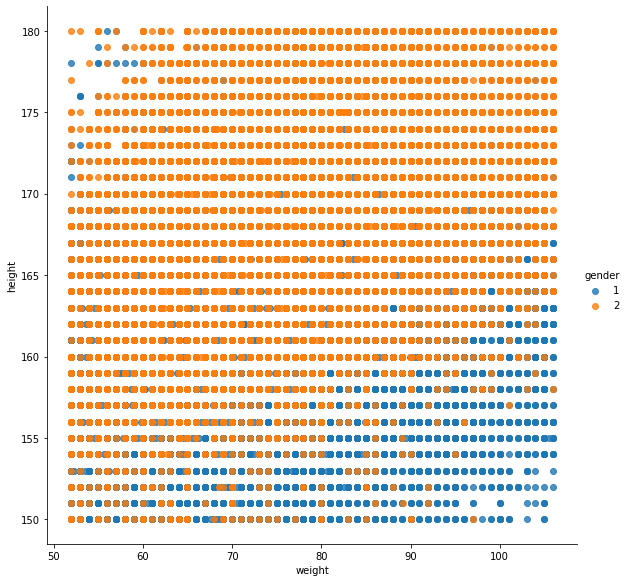

In [12]:
sns.lmplot(x="weight", y="height", hue="gender", data=cardio, fit_reg=False, height=8)
cardio["bmi"] = (cardio["weight"]/(cardio["height"]/100)**2)          

### Shows the data with the addition of BMI column

In [13]:
cardio.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50.0,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,55.0,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,52.0,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,48.0,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,48.0,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


#### Visualization using Histogram

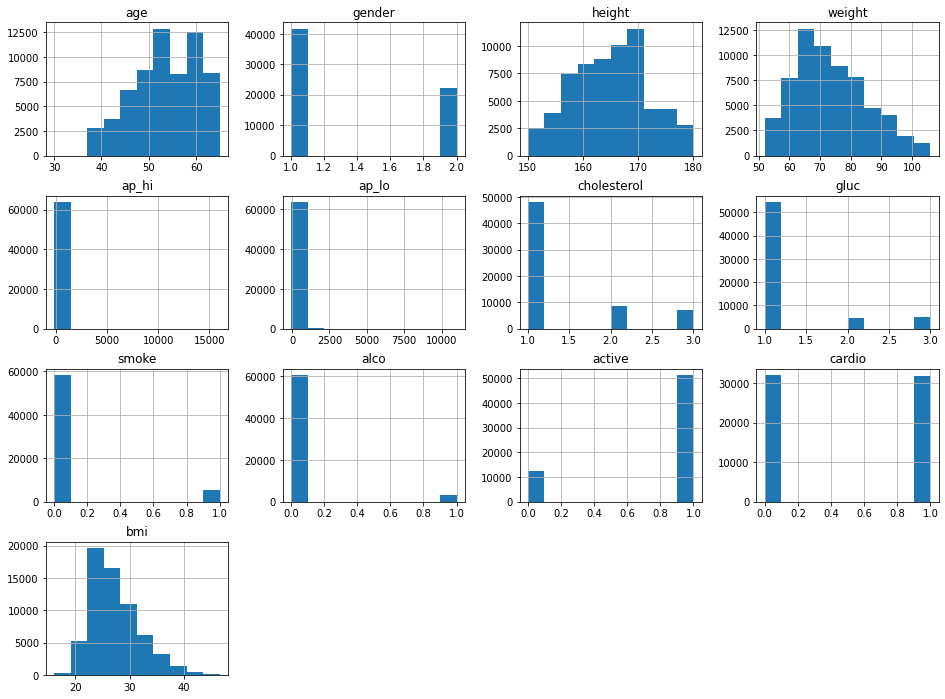

In [14]:
cardio.hist(linewidth=2, figsize=(16,12))
plt.show();

### Have a look at our target variable Cardio

c:\users\sirle\opencv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


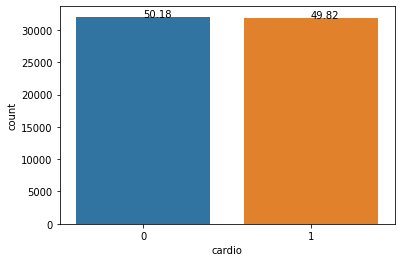

In [15]:
fig, ax = plt.subplots(1,1)
sns.countplot(cardio['cardio'], ax=ax)
for i in ax.patches:
    height = i.get_height()
    ax.text(i.get_x()+i.get_width()/2,height,'{:.2f}'.format((i.get_height()/len(cardio['cardio']))*100,'%'))
plt.show()

### Bmi count distribution

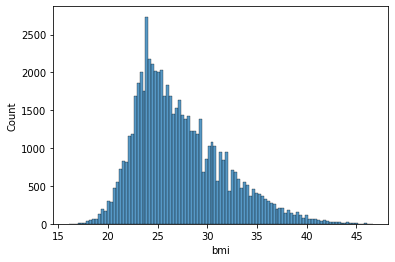

In [16]:
sns.histplot(cardio['bmi'])
plt.show()

### BMI distribution by Gender

Smoker women have higher risks for cardio disease than men based on thier BMI

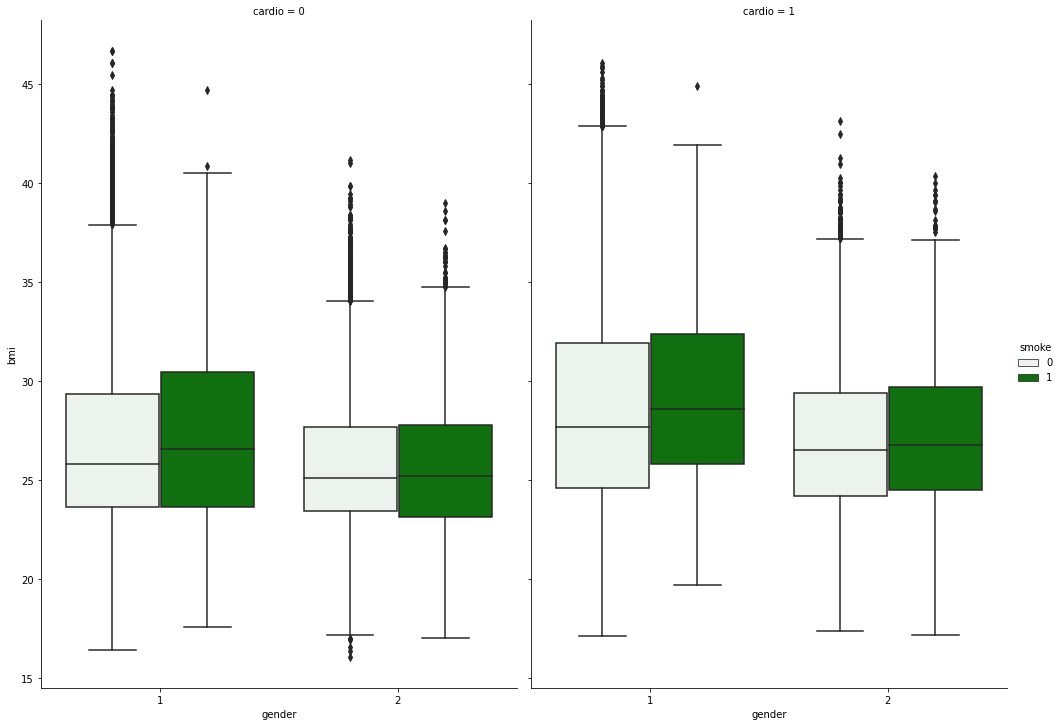

In [17]:
sns.catplot(x="gender", y="bmi", hue="smoke", col ="cardio", data=cardio, color = "green",kind="box", height=10, aspect=.7);

### Analyse of the Cardio vs Cholesterol
Where we can see the distribution of level 1 to 3 of Cholesterol in relation of person with no cardio disease and the Cardio presence(yes.
### Second graphic shows Cardio vc Glucose

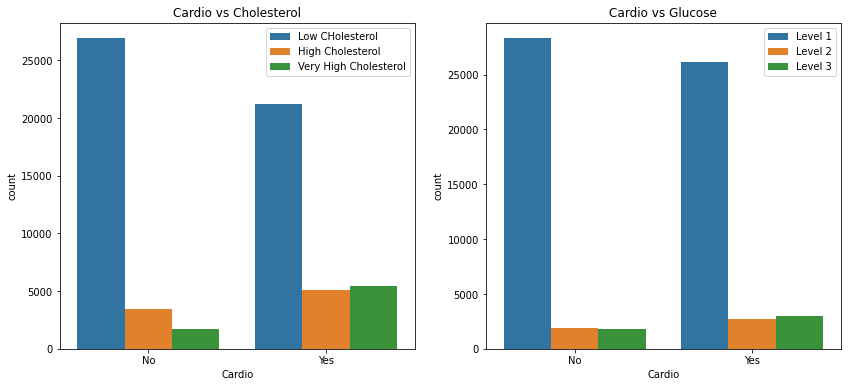

In [18]:
fig, ax =plt.subplots(1,2,figsize=(14,6))
sns.countplot(x=cardio["cardio"],hue=cardio["cholesterol"],ax=ax[0])
sns.countplot(x=cardio["cardio"],hue=cardio["gluc"],ax=ax[1])
ax[0].set_title("Cardio vs Cholesterol")
ax[1].set_title("Cardio vs Glucose")
ax[0].set_xlabel("Cardio")
ax[1].set_xlabel("Cardio")
ax[0].set_xticklabels(["No","Yes"])
ax[1].set_xticklabels(["No","Yes"])
ax[0].legend(["Low CHolesterol","High Cholesterol","Very High Cholesterol"],loc="upper right")
ax[1].legend(["Level 1","Level 2","Level 3"],loc="upper right")
plt.show()

## Feature Engineering

### Reading Blood pressure and Understanding Diastolic and Systolic pressure

In [19]:
#Eliminate negative min values for  ap_hi and ap_lo and max values that does not make sense.
outlier_bp1 = ((cardio["ap_hi"] > 250) | (cardio["ap_lo"] > 160))
outlier_bp2 = ((cardio["ap_hi"] < 80) | (cardio["ap_lo"] < 30))
cardio = cardio[~outlier_bp1]
cardio = cardio[~outlier_bp2]

<ipython-input-19-696955be3cdc>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cardio = cardio[~outlier_bp2]


In [20]:
cardio.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
count,62772.000000,62772.000000,62772.000000,62772.000000,62772.000000,62772.000000,62772.000000,62772.000000,62772.000000,62772.000000,62772.000000,62772.000000,62772.000000
mean,53.336440,1.347113,164.503999,73.489308,126.492624,81.309517,1.357197,1.222249,0.086249,0.052603,0.803495,0.493707,27.210516
std,6.751657,0.476056,6.854482,11.694924,16.375619,9.409223,0.673640,0.568602,0.280733,0.223242,0.397358,0.499964,4.434758
min,30.000000,1.000000,150.000000,52.000000,80.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,16.049383
25%,48.000000,1.000000,160.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.291724
75%,58.000000,2.000000,169.000000,81.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,29.760863
max,65.000000,2.000000,180.000000,106.000000,240.000000,160.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,46.666667


## Create a column adding Blood Pressure Category - BPC

#### Blood pressure range by the American Heart Association (AHA)
* Category 1 =  (ap_hi) systolic pressure < 120 and (ap_lo) diastolic pressure < 80 mm Hg.


* Category 2 =  (ap_hi) systolic pressure >= 120 & < 130 and (ap_lo) diastolic pressure < 80 mm Hg.


* Category 3 =  (ap_hi) systolic pressure >= 130 & < 140 and (ap_lo) diastolic pressure >= 80 & < 90 mm Hg.


* Category 4 =  (ap_hi) systolic pressure >= 140 & < 180 and (ap_lo) diastolic pressure >= 90 & < 120 mm Hg.


* Category 5 =  (ap_hi) systolic pressure >= 180 and (ap_lo) diastolic pressure >= 120 mm Hg.

#### Category description:

Category 1 and 2 is considered normal blood pressure.

Category 3 is High blood pressure and considered stage 1 hypertension.

Category 4 is more serious condition and considered stage 2 hypertension.

Category 5 is a serious health problem and requires urgent treatment.


Ref: https://www.healthline.com/health/high-blood-pressure-hypertension/blood-pressure-reading-explained

In [21]:
cardio['BPC'] = 0

cardio.loc[(cardio['ap_hi'] < 120) & (cardio['ap_lo'] < 80), 'BPC'] = 1

cardio.loc[((cardio['ap_hi'] >= 120) & (cardio['ap_hi'] < 130)) &
         ((cardio['ap_lo'] < 80)), 'BPC'] = 2

cardio.loc[((cardio['ap_hi'] >= 130) & (cardio['ap_hi'] < 140)) |
         ((cardio['ap_lo'] >= 80) & (cardio['ap_lo'] < 90)), 'BPC'] = 3

cardio.loc[((cardio['ap_hi'] >= 140) & (cardio['ap_hi'] < 180)) |
         ((cardio['ap_lo'] >= 90) & (cardio['ap_lo'] < 120)), 'BPC'] = 4

cardio.loc[(cardio['ap_hi'] >= 180) | (cardio['ap_lo'] >= 120), 'BPC'] = 5

cols_ap_ = ['ap_hi', 'ap_lo']
cardio.drop(cols_ap_, axis= 1, inplace= True)

In [22]:
cardio.head()

,age,gender,height,weight,cholesterol,gluc,smoke,alco,active,cardio,bmi,BPC
0,50.0,2,168,62.0,1,1,0,0,1,0,21.967120,3
1,55.0,1,156,85.0,3,1,0,0,1,1,34.927679,4
2,52.0,1,165,64.0,3,1,0,0,0,1,23.507805,3
3,48.0,2,169,82.0,1,1,0,0,1,1,28.710479,4
4,48.0,1,156,56.0,1,1,0,0,0,0,23.011177,1


## Compare the BMI flutuation and the Category level of Blood Pressure
 Clearly we can see that ndividuals with BMI higher than 28 are in the risk level of Hypertension.

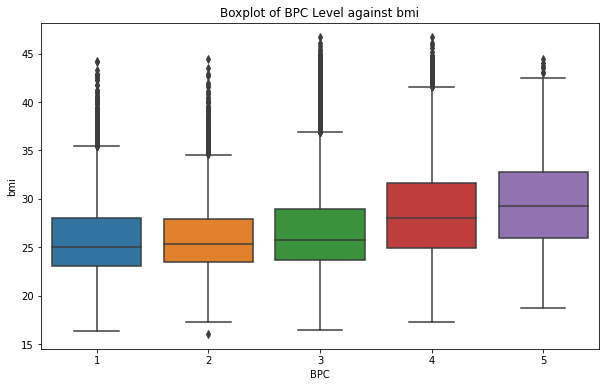

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
ax=sns.boxplot(x=cardio["BPC"],y=cardio["bmi"])
ax.set_title("Boxplot of BPC Level against bmi")
ax.set_xticklabels(["1","2","3","4","5"])
ax.set_xlabel("BPC")
ax.set_ylabel("bmi")
plt.show()

## Plot a violin to see the distribution of bmi across gender
It is found out that a significant portion of women have a high level of BMI compare with men, also women BMI is quiet significantly
scalled if compare with men.

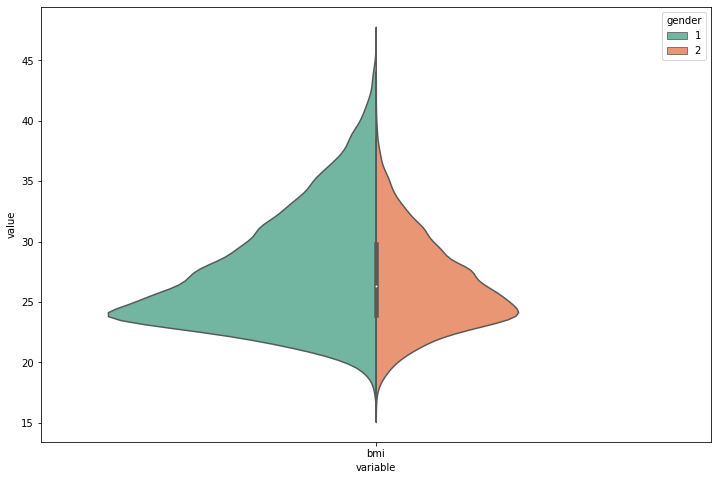

In [24]:
import warnings
warnings.filterwarnings("ignore")
cardio_melt = pd.melt(frame=cardio, value_vars=['bmi'], id_vars=['gender'])
plt.figure(figsize=(12, 8))
ax = sns.violinplot(
    x='variable', 
    y='value', 
    hue='gender', 
    split=True, 
    data=cardio_melt, 
    scale='count',
    scale_hue=False,
    palette="Set2");

After some data exploration, filter and clean of negative values, our cardio dataset end up with 62772 entries and 12 features

In [25]:
cardio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62772 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          62772 non-null  float64
 1   gender       62772 non-null  int64  
 2   height       62772 non-null  int64  
 3   weight       62772 non-null  float64
 4   cholesterol  62772 non-null  int64  
 5   gluc         62772 non-null  int64  
 6   smoke        62772 non-null  int64  
 7   alco         62772 non-null  int64  
 8   active       62772 non-null  int64  
 9   cardio       62772 non-null  int64  
 10  bmi          62772 non-null  float64
 11  BPC          62772 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 8.7 MB


### Pairplot
Considered just numeric data and excluding the binary variables and gender.

<Figure size 1440x1008 with 0 Axes>

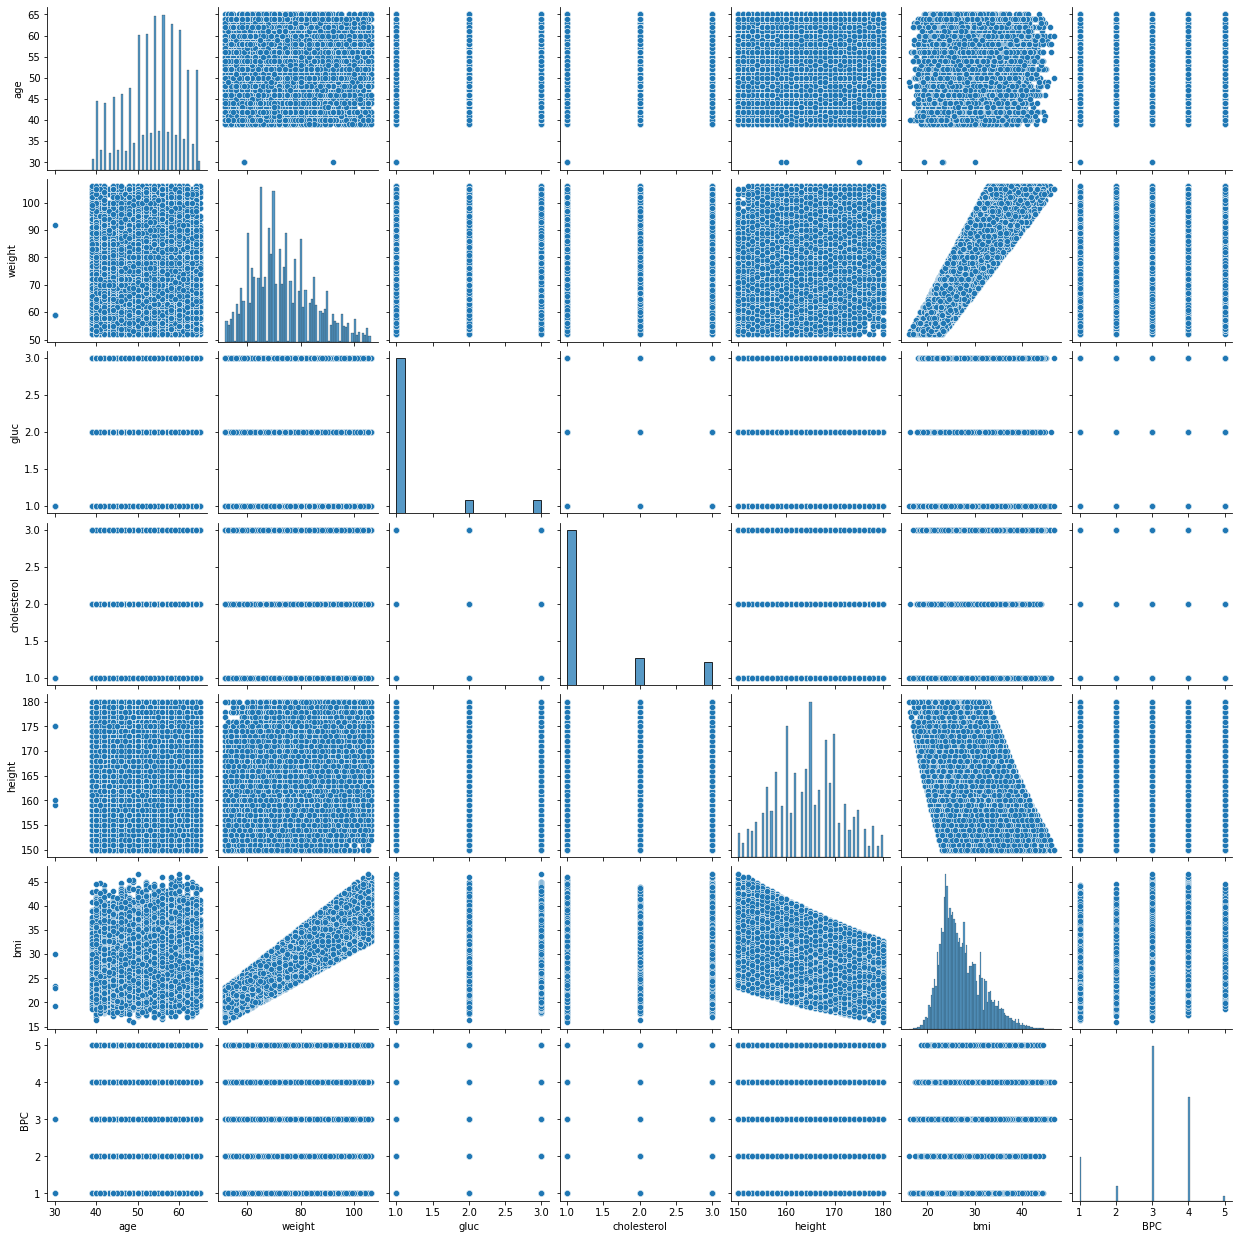

In [26]:
subData = cardio[['age','weight', 'gluc','cholesterol','height', 'bmi', 'BPC']]
plt.figure(figsize=(20, 14))
sns.pairplot(subData)
plt.show()

## Plotting correlations on a heatmap

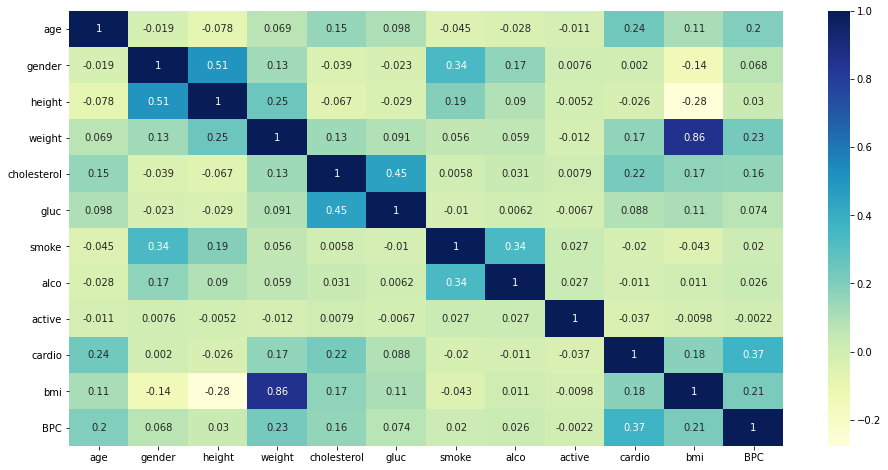

In [27]:
plt.figure(figsize=(16,8))

cor = cardio.corr()
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

### Spliting the data into X and y to build a model

In [28]:
X = cardio.loc[:, ['age', 'gender', 'height', 'weight', 'cholesterol', 'active', 'gluc', 'smoke', 'alco', 'bmi', 'BPC']]

y = cardio['cardio']

Scaling the features and store the column names in cols and convert the X into  numpy array

In [29]:
from sklearn.preprocessing import scale

cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['age', 'gender', 'height', 'weight', 'cholesterol', 'active', 'gluc',
       'smoke', 'alco', 'bmi', 'BPC'],
      dtype='object')

## Model: Decision Tree Classifier

#### First split 10% test and 90% trainning

In [30]:
X = cardio.loc[:, ['age', 'gender','height', 'weight','cholesterol','active','gluc', 'smoke','alco', 'bmi', 'BPC']]
y = cardio['cardio']

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=12345)

In [32]:
# Finally, make the second split to create the final training set and the validation set:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=12345)

In [33]:
X_train.head()

,age,gender,height,weight,cholesterol,active,gluc,smoke,alco,bmi,BPC
5110,46.0,1,168,62.0,1,1,1,0,0,21.967120,4
43206,53.0,2,170,61.0,1,1,1,0,0,21.107266,3
15387,50.0,2,164,62.0,1,0,1,0,0,23.051755,3
25690,56.0,2,179,90.0,1,1,1,0,0,28.089011,3
58544,48.0,2,175,97.0,1,1,1,0,0,31.673469,4


In [34]:
X_test.head()

,age,gender,height,weight,cholesterol,active,gluc,smoke,alco,bmi,BPC
2825,60.0,1,161,62.0,2,1,2,0,0,23.918830,4
60657,52.0,1,153,82.0,1,1,1,0,0,35.029262,3
22676,46.0,1,162,65.0,2,1,1,0,0,24.767566,1
11969,60.0,2,168,60.0,1,1,1,0,0,21.258503,3
21915,40.0,2,168,69.0,1,1,1,1,0,24.447279,3


In [35]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'gini', random_state=12345, max_depth=3)
dt.fit(X,y)
print(f'Train Accuracy for Decision Tree is : {dt.score(X,y)}')

Train Accuracy for Decision Tree is : 0.7162588415216976


### Creating a Decision Tree classifier object, train it.

Than predict the response for test dataset.

In [36]:
clf = DecisionTreeClassifier(max_depth = 3, random_state = 12345)

clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

#### Print how often is the Model Accuracy classifier correct

In [37]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7193373685887225


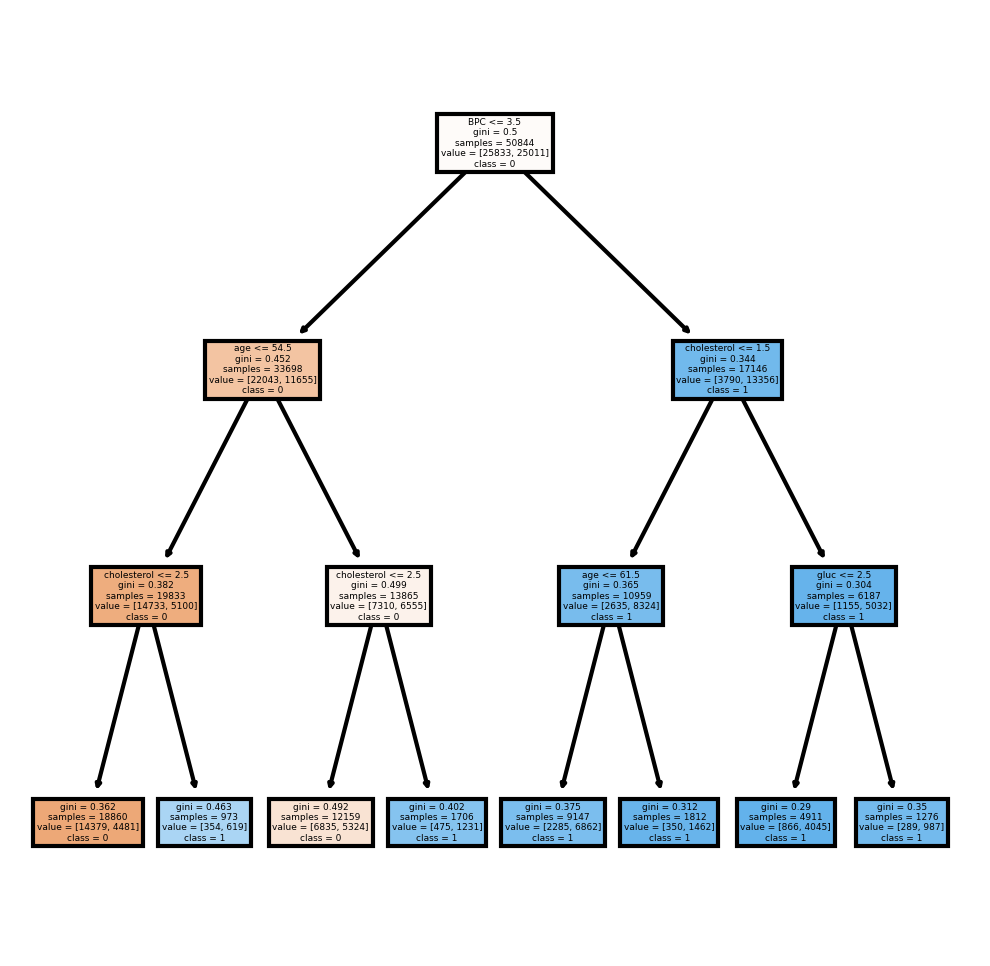

In [38]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# column names for dataset
fn=['age', 'gender', 'height', 'weight', 'cholesterol', 'active', 'gluc', 'smoke', 'alco', 'bmi', 'BPC']
# classes of dataset
cn=['0','1']

# Setting dpi = 300 to make image clearer than default
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)

tree.plot_tree(clf,
           feature_names = fn, 
           class_names=cn,
           filled = True);

Train the same 10% split for test but this time increase the **max_depth=5**, we got an increase nearly to 1%

In [39]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'gini', random_state=12345, max_depth=5)
dt.fit(X,y)
print(f'Train Accuracy for Decision Tree is : {dt.score(X,y)}')

Train Accuracy for Decision Tree is : 0.7236188109348117


In [40]:
clf = DecisionTreeClassifier(max_depth = 5, random_state = 12345)

clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

#### Print how often is the Model Accuracy classifier correct

In [41]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7242752468939153


### 20% test 80% train

In [42]:
X = cardio.loc[:, ['age', 'gender', 'height', 'weight', 'cholesterol', 'active', 'gluc', 'smoke', 'alco', 'bmi', 'BPC']]
y = cardio['cardio']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12345)

In [44]:
dt = DecisionTreeClassifier(criterion = 'gini', random_state=12345, max_depth=3)
dt.fit(X,y)
print(f'Train Accuracy for Decision Tree is : {dt.score(X,y)}')

Train Accuracy for Decision Tree is : 0.7162588415216976


In [45]:
clf = DecisionTreeClassifier(max_depth = 3, random_state = 12345)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [46]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7151732377538829


### 30% test 70% train

In [47]:
X = cardio.loc[:, ['age', 'gender', 'height', 'weight', 'cholesterol', 'active', 'gluc', 'smoke', 'alco', 'bmi', 'BPC']]
y = cardio['cardio']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=12345)

In [49]:
dt = DecisionTreeClassifier(criterion = 'gini', random_state=12345, max_depth=3)
dt.fit(X,y)
print(f'Train Accuracy for Decision Tree is : {dt.score(X,y)}')

Train Accuracy for Decision Tree is : 0.7162588415216976


In [50]:
clf = DecisionTreeClassifier(max_depth = 3, random_state = 12345)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [51]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7172366185216652


Train the same 30% split for test but this time increase the **max_depth=5**, we got less than 1% increase.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=12345)

In [53]:
dt = DecisionTreeClassifier(criterion = 'gini', random_state=12345, max_depth=5)
dt.fit(X,y)
print(f'Train Accuracy for Decision Tree is : {dt.score(X,y)}')

Train Accuracy for Decision Tree is : 0.7236188109348117


In [54]:
clf = DecisionTreeClassifier(max_depth = 5, random_state = 12345)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [55]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7219095157179269


### Visualization of Blood Pressure categories by group age

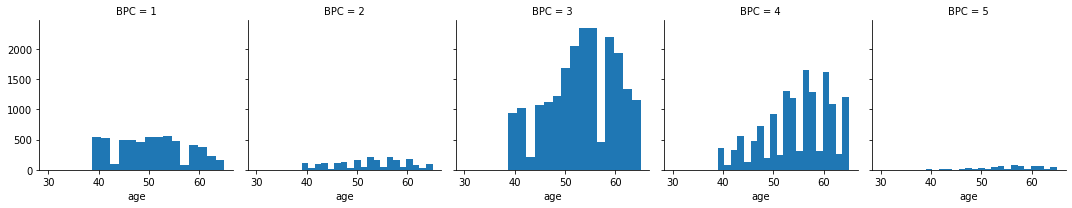

In [56]:
g = sns.FacetGrid(X_train, col='BPC')
g.map(plt.hist, 'age', bins=20);

# Random Forest 

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.metrics import f1_score

In [58]:
classifiers = {'Random Forest' : RandomForestClassifier()}

### First split 10% test 90% train

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=12345)

In [60]:
results=pd.DataFrame(columns=['Accuracy in %','F1-score'])
for method,func in classifiers.items():
    func.fit(X_train,y_train)
    pred = func.predict(X_test)
    results.loc[method]= [100*np.round(accuracy_score(y_test,pred),decimals=4),
                         round(f1_score(y_test,pred),2)]

In [61]:
param_grid = {'max_depth': [80, 90],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200]}
grid=GridSearchCV(RandomForestClassifier(),param_grid,verbose=1)
grid.fit(X_train,y_train)
grid.best_params_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 20.1min finished


{'max_depth': 90,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

In [62]:
import pandas as pd
from sklearn.metrics import classification_report

In [63]:
grid_pred = grid.predict(X_test)
print(classification_report(y_test,grid_pred))

              precision    recall  f1-score   support

           0       0.71      0.74      0.73      3161
           1       0.73      0.70      0.71      3117

    accuracy                           0.72      6278
   macro avg       0.72      0.72      0.72      6278
weighted avg       0.72      0.72      0.72      6278



#### Second Split 20% test and 80% train

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12345)

In [65]:
results=pd.DataFrame(columns=['Accuracy in %','F1-score'])
for method,func in classifiers.items():
    func.fit(X_train,y_train)
    pred = func.predict(X_test)
    results.loc[method]= [100*np.round(accuracy_score(y_test,pred),decimals=4),
                         round(f1_score(y_test,pred),2)]

In [66]:
param_grid = {'max_depth': [80, 90],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200]}
grid=GridSearchCV(RandomForestClassifier(),param_grid,verbose=1)
grid.fit(X_train,y_train)
grid.best_params_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 17.7min finished


{'max_depth': 90,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}

In [67]:
grid_pred = grid.predict(X_test)
print(classification_report(y_test,grid_pred))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      6330
           1       0.73      0.69      0.71      6225

    accuracy                           0.72     12555
   macro avg       0.72      0.72      0.72     12555
weighted avg       0.72      0.72      0.72     12555



#### Split 30% test and 70% train

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=12345)

In [69]:
results=pd.DataFrame(columns=['Accuracy in %','F1-score'])
for method,func in classifiers.items():
    func.fit(X_train,y_train)
    pred = func.predict(X_test)
    results.loc[method]= [100*np.round(accuracy_score(y_test,pred),decimals=4),
                         round(f1_score(y_test,pred),2)]

In [70]:
param_grid = {'max_depth': [80, 90],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200]}
grid=GridSearchCV(RandomForestClassifier(),param_grid,verbose=1)
grid.fit(X_train,y_train)
grid.best_params_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 15.4min finished


{'max_depth': 90,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

In [71]:
grid_pred = grid.predict(X_test)
print(classification_report(y_test,grid_pred))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      9508
           1       0.73      0.69      0.71      9324

    accuracy                           0.72     18832
   macro avg       0.72      0.72      0.72     18832
weighted avg       0.72      0.72      0.72     18832



## Logistic Regression 

In [72]:
X = cardio.loc[:, ['age', 'gender', 'height', 'weight', 'cholesterol', 'active', 'gluc', 'smoke', 'alco', 'bmi', 'BPC']]
y = cardio['cardio']

### First split 10% test and 90% train

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=12345)

In [74]:
log = LogisticRegression()
log.fit(X_train, y_train)
y_pred = log.predict(X_test)
acc_log = round(log.score(X_train, y_train) * 100, 2)
acc_log

70.86

In [75]:
acc_test_log = round(log.score(X_test, y_test) * 100, 2)
acc_test_log

70.55

#### Model evaluation using Confusion Matrix

In [76]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[2211,  950],
       [ 899, 2218]], dtype=int64)

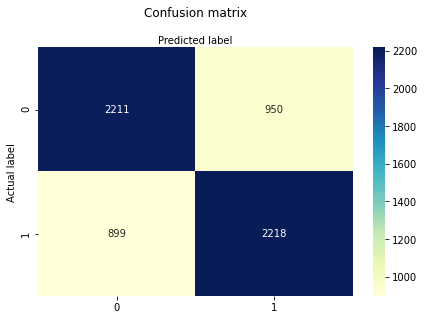

In [77]:
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

In [78]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) 

Accuracy: 0.7054794520547946
Precision: 0.7001262626262627
Recall: 0.711581649021495


#### ROC curve
Plot the true positive rate against the false positive rate

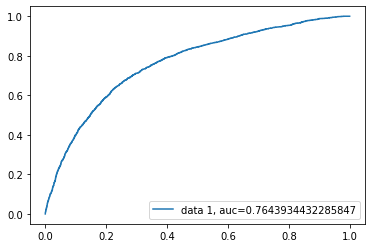

In [79]:
y_pred_proba = log.predict_proba(X_test)[::,1]
fpr, tpr,_ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc=" +str(auc))
plt.legend(loc=4);

### Second split 20% test and 80% train

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12345)

In [81]:
log = LogisticRegression()
log.fit(X_train, y_train)
y_pred = log.predict(X_test)
acc_log = round(log.score(X_train, y_train) * 100, 2)
acc_log

70.86

In [82]:
acc_test_log = round(log.score(X_test, y_test) * 100, 2)
acc_test_log

70.82

#### Model evaluation using Confusion Matrix

In [83]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[4465, 1865],
       [1798, 4427]], dtype=int64)

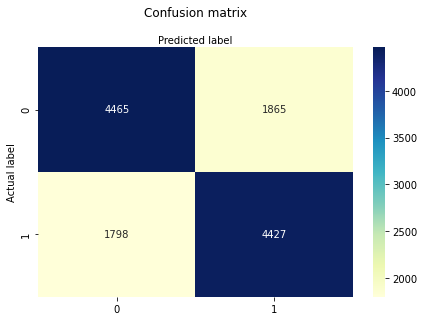

In [84]:
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

In [85]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) 

Accuracy: 0.7082437275985664
Precision: 0.7035918626827717
Recall: 0.7111646586345381


#### ROC curve
Plot the true positive rate against the false positive rate

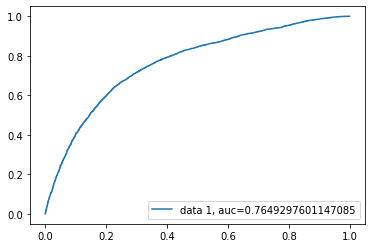

In [86]:
y_pred_proba = log.predict_proba(X_test)[::,1]
fpr, tpr,_ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc=" +str(auc))
plt.legend(loc=4);

### Third split 30% test and 70% train

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=12345)

In [88]:
log = LogisticRegression()
log.fit(X_train, y_train)
y_pred = log.predict(X_test)
acc_log = round(log.score(X_train, y_train) * 100, 2)
acc_log

70.81

In [89]:
acc_test_log = round(log.score(X_test, y_test) * 100, 2)
acc_test_log

70.99

#### Model evaluation using Confusion Matrix

In [90]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[6702, 2806],
       [2657, 6667]], dtype=int64)

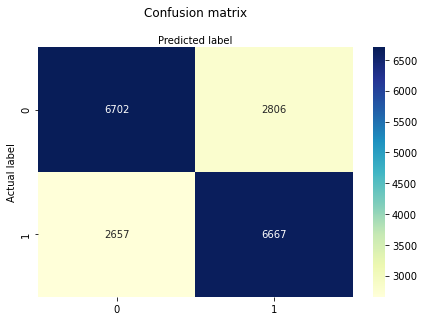

In [91]:
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

In [92]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) 

Accuracy: 0.7099086661002549
Precision: 0.7037897181463105
Recall: 0.715036465036465


#### ROC curve
Plot the true positive rate against the false positive rate

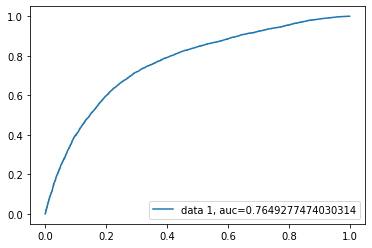

In [93]:
y_pred_proba = log.predict_proba(X_test)[::,1]
fpr, tpr,_ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc=" +str(auc))
plt.legend(loc=4);

### Logistic Regression using Hyperparameter C and GridSearchCV

In [94]:
X = cardio.loc[:, ['age', 'gender', 'height', 'weight', 'cholesterol', 'active', 'gluc', 'smoke', 'alco', 'bmi', 'BPC']]

y = cardio['cardio']

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=12345)

In [96]:
X_train = cardio.drop(['cardio'],axis=1)
y_train = cardio.filter(['cardio'])
X_test = cardio.drop(['cardio'],axis=1)
y_test = cardio.filter(['cardio'])

In [97]:
logistic_model = LogisticRegression(random_state = 12345, max_iter = 5000, penalty = 'l2')

In [98]:
tune_grid = {
 'C' : np.arange(0.01, 1, 0.01)
}
tune_grid

{'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
        0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
        0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
        0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
        0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
        0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
        0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
        0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
        0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])}

In [99]:
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=12345)

In [100]:
opt = GridSearchCV(
 logistic_model, tune_grid, scoring='f1',
 cv=cv, n_jobs=1)
opt_results = opt.fit(X_train, y_train['cardio'])

In [101]:
format_string = 'Average cross-validated in-sample F1 score {:.3f} {}'
print(format_string.format(opt_results.best_score_,str(opt_results.best_params_)))

Average cross-validated in-sample F1 score 0.705 {'C': 0.01}


In [102]:
logistic_model = LogisticRegression(
 random_state = 12345,
 C = opt_results.best_params_ ['C'],
 max_iter = 5000,
 penalty = 'l2',
 solver='liblinear')
logistic_model.fit(X_train,y_train['cardio'])

LogisticRegression(C=0.01, max_iter=5000, random_state=12345,
                   solver='liblinear')

In [103]:
y_predicted = logistic_model.predict(X_test)

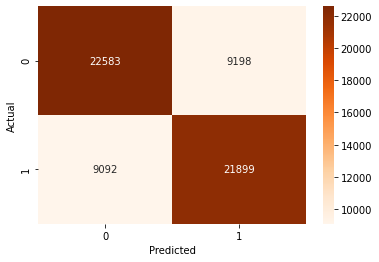

In [104]:
data = {'Actual': y_test['cardio'],
 'Predicted': y_predicted
 }
df = pd.DataFrame(data, columns=['Actual','Predicted'])
confusion_matrix = pd.crosstab(df['Actual'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'])
_ = sns.heatmap(confusion_matrix, annot=True, cmap='Oranges', fmt='g')

In [105]:
print('F1 Score, {:3f}'.format(f1_score(y_test['cardio'],y_predicted)))

F1 Score, 0.705418


# Artificial Neuro Network

Having tried combinations of number of epochs used in the model (50, 100, 160, 200) and activation functions used 'relu', 'sigmoid' we can conlude that the greatest accuracy is achieved by using the sigmoid function across all three layers.

For this model, we will use the 'sigmoid' activation function, with 100 epochs.

We tested adding an additional layer which had little affect on accuracy.

We also tested a number of batch sizes which had little affect also.

In [106]:
from sklearn.preprocessing import scale
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['age', 'gender', 'height', 'weight', 'cholesterol', 'active', 'gluc',
       'smoke', 'alco', 'bmi', 'BPC'],
      dtype='object')

In [107]:
X = cardio.drop(['cardio'], axis=1)
Y = cardio['cardio']

### Building the model

In [108]:
model = Sequential()
model.add(Dense(32, input_dim=11, activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

In [109]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

#### First split - 10% test 90% train

In [110]:
history = model.fit(X, Y,validation_split=0.10, epochs=100, batch_size=16,callbacks=[tbCallBack])

Epoch 1/100
   1/3531 [..............................] - ETA: 0s - loss: 0.6980 - accuracy: 0.6250WARNING:tensorflow:From c:\users\sirle\opencv\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
3531/3531 [==============================] - 4s 1ms/step - loss: 0.6322 - accuracy: 0.6456 - val_loss: 0.5949 - val_accuracy: 0.6881
Epoch 2/100
3531/3531 [==============================] - 4s 994us/step - loss: 0.5881 - accuracy: 0.6982 - val_loss: 0.5856 - val_accuracy: 0.7069
Epoch 3/100
3531/3531 [==============================] - 4s 1ms/step - loss: 0.5818 - accuracy: 0.7071 - val_loss: 0.5900 - val_accuracy: 0.6935
Epoch 4/100
3531/3531 [==============================] - 3s 982us/step - loss: 0.5801 - accuracy: 0.7093 - val_loss: 0.5849 - val_accuracy: 0.7009
Epoch 5/100
3531/3531 [============================

In [111]:
scores = model.evaluate(X, Y)

print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

1962/1962 [==============================] - 1s 704us/step - loss: 0.5639 - accuracy: 0.7257

accuracy: 72.57%


In [112]:
model.predict(X)

array([[0.23104405],
       [0.82201767],
       [0.76717997],
       ...,
       [0.24021226],
       [0.5408641 ],
       [0.42692727]], dtype=float32)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


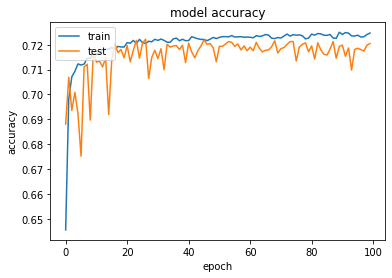

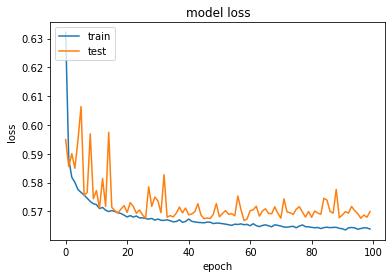

In [113]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [114]:
import numpy
myX_false = [[47,1,156,56.0,100,60,1,1,0,0,0]]
myX_true = [[48,2,169,82.0,150,100,1,1,0,0,1]]
matrixX=numpy.array(myX_false, dtype = numpy.float64)
X_input = matrixX[:,0:11]
model.predict(X_input)

array([[0.8421238]], dtype=float32)

#### Second split - 20% test 80% train

In [115]:
history = model.fit(X, Y,validation_split=0.20, epochs=100, batch_size=16,callbacks=[tbCallBack])

Epoch 1/100
3139/3139 [==============================] - 4s 1ms/step - loss: 0.5632 - accuracy: 0.7252 - val_loss: 0.5712 - val_accuracy: 0.7235
Epoch 2/100
3139/3139 [==============================] - 3s 1ms/step - loss: 0.5633 - accuracy: 0.7236 - val_loss: 0.5680 - val_accuracy: 0.7242
Epoch 3/100
3139/3139 [==============================] - 3s 1ms/step - loss: 0.5632 - accuracy: 0.7248 - val_loss: 0.5677 - val_accuracy: 0.7223
Epoch 4/100
3139/3139 [==============================] - 4s 1ms/step - loss: 0.5634 - accuracy: 0.7250 - val_loss: 0.5698 - val_accuracy: 0.7170
Epoch 5/100
3139/3139 [==============================] - 3s 1ms/step - loss: 0.5634 - accuracy: 0.7240 - val_loss: 0.5703 - val_accuracy: 0.7188
Epoch 6/100
3139/3139 [==============================] - 3s 1ms/step - loss: 0.5637 - accuracy: 0.7226 - val_loss: 0.5699 - val_accuracy: 0.7154
Epoch 7/100
3139/3139 [==============================] - 3s 1ms/step - loss: 0.5634 - accuracy: 0.7240 - val_loss: 0.5688 - val_ac

In [116]:
scores = model.evaluate(X, Y)

print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

1962/1962 [==============================] - 2s 770us/step - loss: 0.5623 - accuracy: 0.7264

accuracy: 72.64%


In [117]:
model.predict(X)

array([[0.2500823 ],
       [0.81677425],
       [0.66307986],
       ...,
       [0.25773665],
       [0.5564257 ],
       [0.3980982 ]], dtype=float32)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


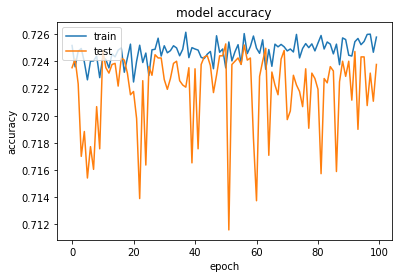

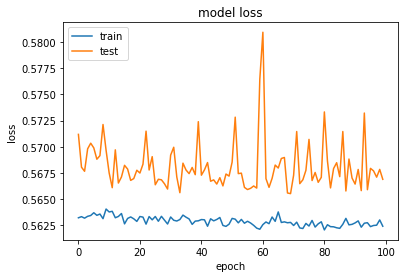

In [118]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [119]:
myX_false = [[47,1,156,56.0,100,60,1,1,0,0,0]]
myX_true = [[48,2,169,82.0,150,100,1,1,0,0,1]]
matrixX=numpy.array(myX_false, dtype = numpy.float64)
X_input = matrixX[:,0:11]
model.predict(X_input)

array([[0.8442049]], dtype=float32)

#### Third split - 30% test 70% train

In [120]:
history = model.fit(X, Y,validation_split=0.30, epochs=100, batch_size=16,callbacks=[tbCallBack])

Epoch 1/100
2747/2747 [==============================] - 4s 1ms/step - loss: 0.5638 - accuracy: 0.7244 - val_loss: 0.5614 - val_accuracy: 0.7264
Epoch 2/100
2747/2747 [==============================] - 4s 1ms/step - loss: 0.5632 - accuracy: 0.7250 - val_loss: 0.5624 - val_accuracy: 0.7257
Epoch 3/100
2747/2747 [==============================] - 4s 1ms/step - loss: 0.5632 - accuracy: 0.7239 - val_loss: 0.5635 - val_accuracy: 0.7247
Epoch 4/100
2747/2747 [==============================] - 4s 1ms/step - loss: 0.5638 - accuracy: 0.7237 - val_loss: 0.5620 - val_accuracy: 0.7255
Epoch 5/100
2747/2747 [==============================] - 4s 1ms/step - loss: 0.5632 - accuracy: 0.7238 - val_loss: 0.5689 - val_accuracy: 0.7146
Epoch 6/100
2747/2747 [==============================] - 4s 1ms/step - loss: 0.5643 - accuracy: 0.7236 - val_loss: 0.5628 - val_accuracy: 0.7242
Epoch 7/100
2747/2747 [==============================] - 4s 1ms/step - loss: 0.5637 - accuracy: 0.7232 - val_loss: 0.5643 - val_ac

In [121]:
scores = model.evaluate(X, Y)

print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

1962/1962 [==============================] - 1s 748us/step - loss: 0.5617 - accuracy: 0.7270

accuracy: 72.70%


In [122]:
model.predict(X)

array([[0.25066584],
       [0.8240818 ],
       [0.78424716],
       ...,
       [0.2509356 ],
       [0.56905013],
       [0.4034432 ]], dtype=float32)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


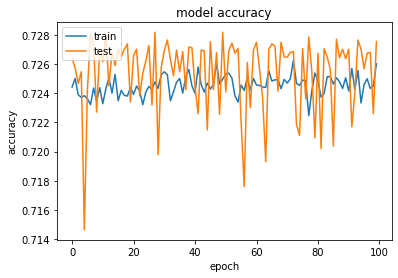

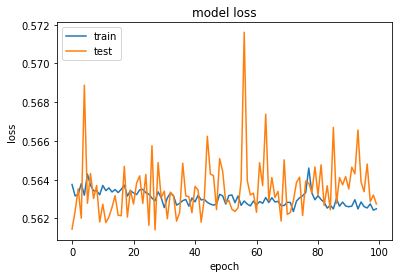

In [123]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [124]:
myX_false = [[47,1,156,56.0,100,60,1,1,0,0,0]]
myX_true = [[48,2,169,82.0,150,100,1,1,0,0,1]]
matrixX=numpy.array(myX_false, dtype = numpy.float64)
X_input = matrixX[:,0:11]
model.predict(X_input)

array([[0.841396]], dtype=float32)

## KNN - KNeighbors

We developed the KNN model but the accuracy is not that great, however we keep here to show our progress.

In [125]:
X = cardio[['age', 'gender', 'BPC', 'active', 'gluc', 'smoke', 'alco', 'bmi', 'cholesterol']]

y = cardio[['cardio']]

In [126]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

<B>Choosing a K Value</b>

Using the Elbow method to choose this value

In [127]:
error_rate = []
for i in range (1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    score = cross_val_score(knn, X, cardio['cardio'], cv=10)
    error_rate.append(1-score.mean())

Text(0, 0.5, 'Error Rate')

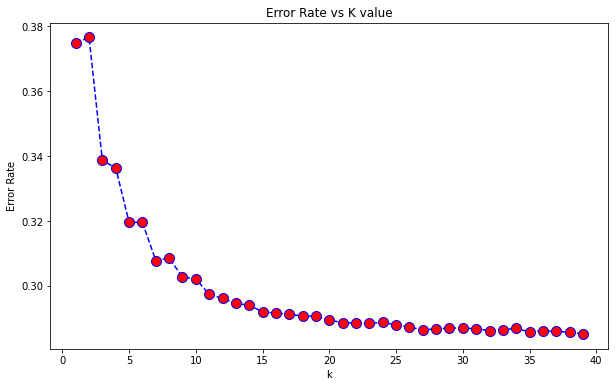

In [128]:
plt.figure(figsize = (10,6))
plt.plot(range(1,40), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
#plt.plot(range(1,40), accuracy_rate, color='blue', linestyle='dashed', marker='o'
# markerfacecolor='red', marker=10)
plt.title('Error Rate vs K value')
plt.xlabel('k')
plt.ylabel('Error Rate')

We can see that after K4, the error rate declines steadily.

In [129]:
k=4
knn = KNeighborsClassifier(n_neighbors=4)

#### First split 10% test and 90 % train

In [130]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=12345)

In [131]:
print('Training Set:', X_train.shape, y_train.shape)
print('Training Set:', X_test.shape, y_test.shape)

Training Set: (56494, 9) (56494, 1)
Training Set: (6278, 9) (6278, 1)


In [132]:
k = 4
from sklearn.metrics import accuracy_score
Knn = KNeighborsClassifier(n_neighbors=4)
Knn.fit(X_train,y_train)
yhat = Knn.predict(X_test)
print('Accuracy Score:',accuracy_score(y_test,yhat))

Accuracy Score: 0.6643835616438356


<b>Second split 20% test and 80 % train</b>

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12345)

In [134]:
print ('Training Set:', X_train.shape, y_train.shape)
print ('Testing Set:', X_test.shape, y_test.shape)

Training Set: (50217, 9) (50217, 1)
Testing Set: (12555, 9) (12555, 1)


In [135]:
k = 4
Knn = KNeighborsClassifier(n_neighbors=4)
Knn.fit(X_train,y_train)
yhat = Knn.predict(X_test)
print('Accuracy Score:',accuracy_score(y_test,yhat))

Accuracy Score: 0.660294703305456


#### Third split 30% test and 70 % train

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=12345)

In [137]:
print ('Training Set:', X_train.shape, y_train.shape)
print ('Testing Set:', X_test.shape, y_test.shape)

Training Set: (43940, 9) (43940, 1)
Testing Set: (18832, 9) (18832, 1)


In [138]:
k = 4
K = KNeighborsClassifier(n_neighbors=4)
Knn.fit(X_train,y_train)
yhat = Knn.predict(X_test)
print('Accuracy Score:',accuracy_score(y_test,yhat))

Accuracy Score: 0.6623831775700935


<b>Prediction and Evaluation</b>

In [139]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [140]:
pred = Knn.predict(X_test)

In [141]:
print(confusion_matrix(y_test, pred))

[[7437 2071]
 [4287 5037]]


In [142]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.63      0.78      0.70      9508
           1       0.71      0.54      0.61      9324

    accuracy                           0.66     18832
   macro avg       0.67      0.66      0.66     18832
weighted avg       0.67      0.66      0.66     18832

